In [3]:
from functools import partial
import os
import pickle
import random
import sys
sys.path.append(f'{os.getcwd()}/../')
print(sys.path)

from lib.models.model_execution_support import fit_linear_predictor
from lib.models.model_execution_support import train_and_forecast
from lib.models.model_execution_support import run_on_inputs_with_targets
from lib.models.model_execution_support import run_mod_with_correction_block_on_inputs_with_targets
from lib.models.recurrent_forecaster_with_correction_block import RecurrentForecasterWithCorrectionBlock
from lib.models.recurrent_sigmoid_piecewise_forecaster import RSPForecaster
from lib.models.recurrent_sigmoid_piecewise_forecaster import StackedRCellsForecaster
from lib.models.recurrent_sigmoid_piecewise_forecaster import GRUForecaster
from lib.models.recurrent_sigmoid_piecewise_forecaster import LSTMForecaster
from lib.models.linear_forecaster import LinearForecaster
from lib.utils.recurrent_contexts_manager import RecurrentContextsManager

import numpy as np
import pandas as pd
import torch

['/home/ivan/my_projects/nau_forecasting', '/home/ivan/miniconda3/envs/ml_env/lib/python38.zip', '/home/ivan/miniconda3/envs/ml_env/lib/python3.8', '/home/ivan/miniconda3/envs/ml_env/lib/python3.8/lib-dynload', '', '/home/ivan/.local/lib/python3.8/site-packages', '/home/ivan/miniconda3/envs/ml_env/lib/python3.8/site-packages', '/home/ivan/miniconda3/envs/ml_env/lib/python3.8/site-packages/opensfm-0.5.2-py3.8.egg', '/home/ivan/my_projects/nau_forecasting../', '/home/ivan/my_projects/nau_forecasting/../', '/home/ivan/my_projects/nau_forecasting/../']


In [2]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
seed_everything(42)

In [3]:
df = pd.read_csv('/home/ivan/Downloads/m5-dataset/M5-dataset/Dataset/sales_train_validation.csv')
test_df = pd.read_csv('/home/ivan/Downloads/m5-dataset/M5-dataset/Dataset/sales_test_validation.csv')

In [4]:
print(len(df.columns))
print(df.shape)
raw_vals = df.values
print(type(raw_vals), raw_vals.shape)

1918
(30490, 1918)
<class 'numpy.ndarray'> (30490, 1918)


In [5]:
products = df.item_id.unique()
depts = df.dept_id.unique()
categories = df.cat_id.unique()
stores = df.store_id.unique()
states = df.state_id.unique()
print(categories)
print(depts)
print(len(products))
print(states)
print(len(stores))

['HOBBIES' 'HOUSEHOLD' 'FOODS']
['HOBBIES_1' 'HOBBIES_2' 'HOUSEHOLD_1' 'HOUSEHOLD_2' 'FOODS_1' 'FOODS_2'
 'FOODS_3']
3049
['CA' 'TX' 'WI']
10


In [6]:
prod_0_sales = df[df.item_id == products[0]].values
prod_0_sales = prod_0_sales[:, 5:].mean(axis=0)
print(prod_0_sales.shape)

(1913,)


In [7]:
timeseries = []
test_timeseries = []
keys = []
for cat in categories:
    for store in stores:
        agg_ts = df[(df.store_id == store) & (df.cat_id == cat)].values[:, 5:].mean(axis=0)
        timeseries.append(agg_ts)
        keys.append((cat, store))
        agg_test_ts = test_df[(test_df.store_id == store) & (test_df.cat_id == cat)].values[:, 5:].mean(axis=0)
        test_timeseries.append(agg_test_ts)

In [8]:
print(len(timeseries))
print(timeseries[10][:10])

30
[0.5176695319961796 0.49665711556829034 0.3753581661891118
 0.38299904489016234 0.3151862464183381 0.3839541547277937
 0.39255014326647564 0.6743075453677173 0.4680038204393505
 0.3123209169054441]


<IPython.core.display.Javascript object>


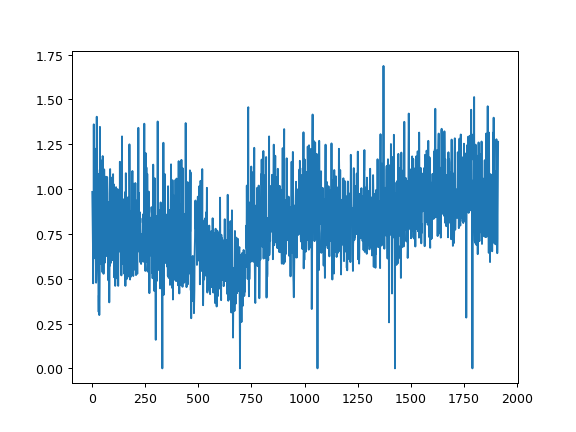

<IPython.core.display.Javascript object>


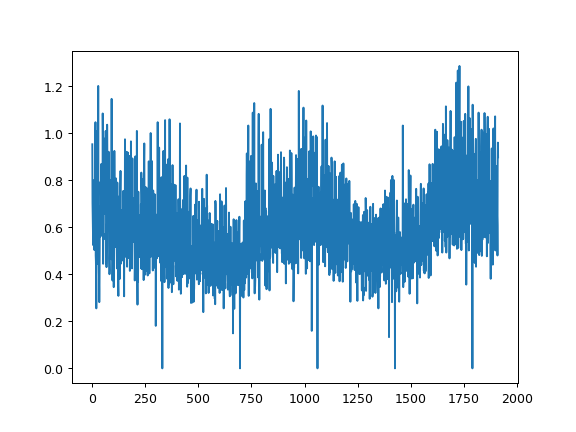

<IPython.core.display.Javascript object>


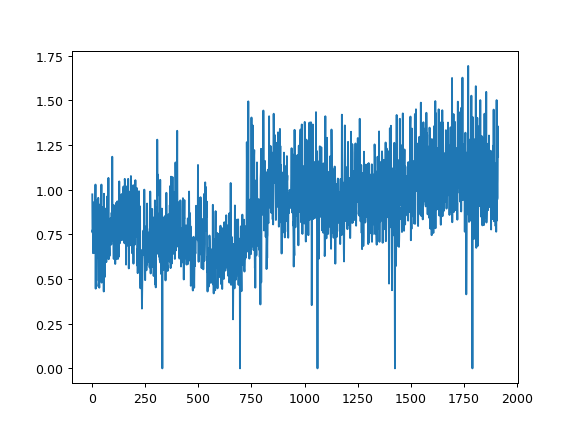

In [9]:
%matplotlib notebook
from matplotlib import pyplot as plt
for i in range(3):
    plt.figure()
    plt.plot(range(len(timeseries[i])), timeseries[i])

In [10]:
DEVICE = 'cpu'
DTYP5E = torch.float32
ts = timeseries[10].astype(np.float32)
print(type(ts), ts.shape, ts.dtype)
print(ts[:10])

<class 'numpy.ndarray'> (1913,) float32
[0.51766956 0.4966571  0.37535816 0.38299903 0.31518623 0.38395417
 0.39255014 0.6743075  0.4680038  0.31232092]


In [11]:
def rmsse(gt, pred, train_ts, h=28):
    n = train_ts.shape[0]
    denom = (h / (n - 1)) * np.square(train_ts[1:] - train_ts[:-1]).sum()
    nom = np.square(gt - pred).sum()
    return np.sqrt(nom / denom)

In [12]:
def get_rsp_neuron_with_norm(cm, inp_size):
    return StackedRCellsForecaster(cm, inp_size, hidden_size=8,
                                   num_cells=3, cell_args={'normalize_ctx': True})


def get_rsp_neuron_without_norm(cm, inp_size):
    return StackedRCellsForecaster(cm, inp_size, hidden_size=8,
                                   num_cells=3, cell_args={'normalize_ctx': False})


def get_gru_neuron(cm, inp_size):
    return StackedRCellsForecaster(cm, inp_size, hidden_size=8,
                                   num_cells=3, CellType=GRUForecaster)

def get_lstm_neuron(cm, inp_size):
    return StackedRCellsForecaster(cm, inp_size, hidden_size=8,
                                   num_cells=3, CellType=LSTMForecaster)


ALL_MODELS = [
    (get_rsp_neuron_with_norm, 'RSP_normed'),
    (get_rsp_neuron_without_norm, 'RSP'),
    (get_gru_neuron, 'GRU'),
    (get_lstm_neuron, 'LSTM')
]
INP_SIZE = 4
NUM_VAL_POINTS = 50
FORECAST_HORIZON = 28
TRY_LOAD_RESULTS_FROM = 'all_results_bigger_models_v1.pickle' # 'all_results_old.pickle'
SAVE_RESULTS_TO = 'all_results_bigger_models_v1.pickle'
RECALC_INDICES = []
cm = RecurrentContextsManager()

In [13]:
all_results = {}
if os.path.exists(TRY_LOAD_RESULTS_FROM):
    with open(TRY_LOAD_RESULTS_FROM, 'rb') as f:
        all_results = pickle.load(f)

if isinstance(all_results, list):
    all_results = {i: res for i, res in enumerate(all_results)}
        
for ts_idx in range(len(timeseries)):
    print(f'Ts idx: {ts_idx}')
    if ts_idx in all_results and ts_idx not in RECALC_INDICES:
        print('Skipping already calculated time series.')
        continue
    ts, test_ts = timeseries[ts_idx], test_timeseries[ts_idx]
    ts_results = {}
    train_inp, train_targ, val_inp, val_targ, lin_train_out, lin_val_out, lin_forecasts, lin_mod = fit_linear_predictor(
        torch.from_numpy(ts.astype(np.float32)),
        INP_SIZE,
        NUM_VAL_POINTS,
        FORECAST_HORIZON,
    )
    ts_results['baseline'] = rmsse(test_ts, lin_forecasts, ts)
    for mod_fn, mod_name in ALL_MODELS:
        forecasts = train_and_forecast(
                partial(mod_fn, cm, INP_SIZE),
                train_inp,
                train_targ,
                val_inp,
                val_targ,
                lin_train_out,
                lin_val_out,
                lin_mod,
                forecast_horizon=FORECAST_HORIZON,
                wd=5e-4,
                max_epochs_wo_improvement=20, # 2,
                # min_epochs=1,
                # max_epochs=10,
                do_print=False,
            )
        #import pdb;pdb.set_trace()
        ts_results[mod_name] = rmsse(test_ts, forecasts, ts)
        print(ts_results)
    all_results[ts_idx] = ts_results
    with open(SAVE_RESULTS_TO, 'wb') as f:
        pickle.dump(all_results, f)

Ts idx: 0
Skipping already calculated time series.
Ts idx: 1
Skipping already calculated time series.
Ts idx: 2
Skipping already calculated time series.
Ts idx: 3
Skipping already calculated time series.
Ts idx: 4
Skipping already calculated time series.
Ts idx: 5
Skipping already calculated time series.
Ts idx: 6
Skipping already calculated time series.
Ts idx: 7
Skipping already calculated time series.
Ts idx: 8
Skipping already calculated time series.
Ts idx: 9
Skipping already calculated time series.
Ts idx: 10
Skipping already calculated time series.
Ts idx: 11
Skipping already calculated time series.
Ts idx: 12
Skipping already calculated time series.
Ts idx: 13
Skipping already calculated time series.
Ts idx: 14
Skipping already calculated time series.
Ts idx: 15
Skipping already calculated time series.
Ts idx: 16
Skipping already calculated time series.
Ts idx: 17
Skipping already calculated time series.
Ts idx: 18
Skipping already calculated time series.
Ts idx: 19
Skipping al

In [14]:
with open(SAVE_RESULTS_TO, 'rb') as f:
    saved_results = pickle.load(f) 
print(len(saved_results))

30


In [15]:
from pprint import pprint
pprint(saved_results)

{0: {'GRU': 0.9077641269940816,
     'LSTM': 0.9660895564149742,
     'RSP': 0.7836595186913499,
     'RSP_normed': 0.6579449796071639,
     'baseline': 1.1347864546856279},
 1: {'GRU': 1.2464339595125105,
     'LSTM': 1.4278985482868767,
     'RSP': 1.25174183027294,
     'RSP_normed': 1.2258436494158085,
     'baseline': 1.5840730327636758},
 2: {'GRU': 0.7085440085136353,
     'LSTM': 0.8978462282221331,
     'RSP': 0.7186416796667806,
     'RSP_normed': 0.6290035664612388,
     'baseline': 0.9456310314069256},
 3: {'GRU': 0.9785501489013398,
     'LSTM': 1.2348151203493762,
     'RSP': 0.9701312986916711,
     'RSP_normed': 0.9488924992288164,
     'baseline': 1.2643785912423773},
 4: {'GRU': 0.9628604779865482,
     'LSTM': 1.181584356526975,
     'RSP': 0.9169100346187294,
     'RSP_normed': 0.9266680107880935,
     'baseline': 1.341383368133236},
 5: {'GRU': 0.9264998086232086,
     'LSTM': 0.9527881751903498,
     'RSP': 0.8824855405254411,
     'RSP_normed': 0.7811569469809864

In [16]:
from collections import defaultdict

per_mod_results = defaultdict(list)

for ts_idx, res in saved_results.items():
    for mod_name, err in res.items():
        per_mod_results[mod_name].append(err)

In [17]:
for mod_name, errs in per_mod_results.items():
    print(f'Avg error for {mod_name}: {np.array(errs).mean()}')

Avg error for baseline: 1.5396515572263325
Avg error for RSP_normed: 0.9919795914156809
Avg error for RSP: 1.0131884802162352
Avg error for GRU: 1.0722590424010032
Avg error for LSTM: 1.2928555152852856
